Chess Game Result Analysis - 401 Project

Berkay Yıldız - 201104087 

Zeynep Meriç Aşık - 201410026

# TODO
-data need to normalize  
--scaling method might be changed, PCA results are not really well, maybe can be solved dimensionally

-EDA must be increased

## After data analysis
-from pearson correlation some columns which have a high correlation with another column can be dropped  
-game duration column can be dropped since it is really skewed and kind of corrupted  
-then PCA can be done to less dimensions and the results would be better  
-also training might get better results

# Importing the Dependencies

In [1]:
#!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns
import plotly.express as px

from random import random
import math
from pyspark import SparkContext
import re
from pyspark.sql import functions as F

In [2]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.conf import SparkConf

from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col, isnull, concat_ws, split, desc, sum, mean, abs, std

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, RobustScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, StringIndexer
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

### func's

In [4]:
def string_to_int(col_name, dataset):
    indexer = StringIndexer(inputCol= col_name , outputCol= col_name+"_ind", stringOrderType="frequencyDesc")
    model = indexer.fit(dataset)
    indexed_dataset = model.transform(dataset)
    #cast double to int and change the dataset
    dataset = indexed_dataset.withColumn(col_name+"_ind", col(col_name+"_ind").cast(IntegerType()))
    grouped_data = dataset.groupBy(col_name).agg(count("*").alias("count"))
    return dict(enumerate(model.labels)),grouped_data, dataset

In [5]:
def printMap_and_showTable(_map,_table):
    print(_map)
    _table.show()

In [6]:
def outlier_treatment(i):
    """function to Remove outlier"""
    sorted_col = dataset.orderBy(dataset.columns[i])
    datacolumn = sorted_col.select(dataset.columns[i])
    percentiles = dataset.approxQuantile(dataset.columns[i], [0.25, 0.75], 0.0)
    Q1, Q3 = percentiles[0], percentiles[1]
    IQR = Q3-Q1
    lower_range = Q1 - (1.5*IQR)
    upper_range = Q3 + (1.5*IQR)
    return lower_range,upper_range,IQR

In [7]:
def count_outliers(i):
    l, u, IQR = outlier_treatment(i)
    count = 0
    if IQR != 0:
        count += dataset.filter((col(dataset.columns[i]) > u) | (col(dataset.columns[i]) < l)).count()
    print("lower: ",l,"- upper: ", u)
    print("will be dropped: ",count)
    return count

In [8]:
""
def drop_outliers(dataset,feature):
    l,u, IQR = outlier_treatment(dataset.columns.index(feature))
    if IQR!=0:
        dataset = dataset.filter((col(feature) <= u) & (col(feature) >= l))
    return dataset

### Spark Build

In [9]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [10]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [11]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

C:\Users\Berkay\anaconda3\envs\newest\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Loading the Data

In [12]:
games = spark.read.format("csv").load("games.csv", header='true', inferSchema='true',  multiline = True)

In [13]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- created_at: double (nullable = true)
 |-- last_move_at: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- increment_code: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [14]:
games = games.withColumnRenamed("created_at", "start_time") \
             .withColumnRenamed("last_move_at", "end_time") \
             .withColumnRenamed("increment_code", "time_increment") 

In [15]:
games.limit(5).toPandas()

,id,rated,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [16]:
games.select("rated", "winner", "opening_name","time_increment","white_rating","black_rating").show(5, truncate=False)

+-----+------+--------------------------------------+--------------+------------+------------+
|rated|winner|opening_name                          |time_increment|white_rating|black_rating|
+-----+------+--------------------------------------+--------------+------------+------------+
|false|white |Slav Defense: Exchange Variation      |15+2          |1500        |1191        |
|true |black |Nimzowitsch Defense: Kennedy Variation|5+10          |1322        |1261        |
|true |white |King's Pawn Game: Leonardis Variation |5+10          |1496        |1500        |
|true |white |Queen's Pawn Game: Zukertort Variation|20+0          |1439        |1454        |
|true |white |Philidor Defense                      |30+3          |1523        |1469        |
+-----+------+--------------------------------------+--------------+------------+------------+
only showing top 5 rows



In [17]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- time_increment: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [18]:
games.describe().toPandas()

,summary,id,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,count,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058
1,mean,None,1.483616852629092E12,1.4836177223361443E12,60.46599860404826,None,None,None,2.6775729307708335E9,1596.6318675840064,5.294535237863636E9,1588.8319872370128,None,None,None,4.8169807558081565
2,stddev,None,2.850150942100429E10,2.850140058889147E10,33.57058475353722,None,None,None,1.1283509443243038E10,291.253375737019,1.8875165053331074E10,291.03612596033423,None,None,None,2.7971518106301025
3,min,005lW0Xz,1.376771633173E12,1.376771863841E12,1,draw,black,0+12,--jim--,784,-0olo0-,789,Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...,A00,Alekhine Defense,1
4,max,zzcDhaYF,1.50449314379E12,1.504493827262E12,349,resign,white,90+8,zzzimon,2700,zztopillo,2723,h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...,E98,Zukertort Opening: Wade Defense,28


In [19]:
missing = games.select([count(when(isnull(c), c)).alias(c) for c in games.columns]).show()

+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
| id|rated|start_time|end_time|turns|victory_status|winner|time_increment|white_id|white_rating|black_id|black_rating|moves|opening_eco|opening_name|opening_ply|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
|  0|    0|         0|       0|    0|             0|     0|             0|       0|           0|       0|           0|    0|          0|           0|          0|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+



No missing (null) values.

# EDA

#### Evaluation by Victory Status

Text(0.5, 1.0, 'Victory Status Occurences')

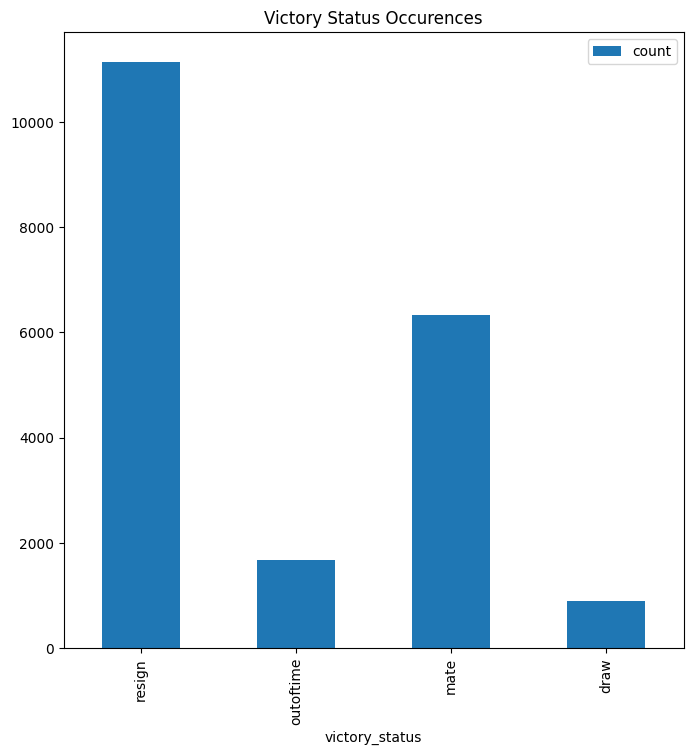

In [20]:
# distribution of the labels
result = games.groupBy("victory_status").count().sort("victory_status", ascending=False)
result.toPandas().plot.bar(x='victory_status',figsize=(8, 8))
plt.title('Victory Status Occurences')

Text(0, 0.5, 'Number of turns')

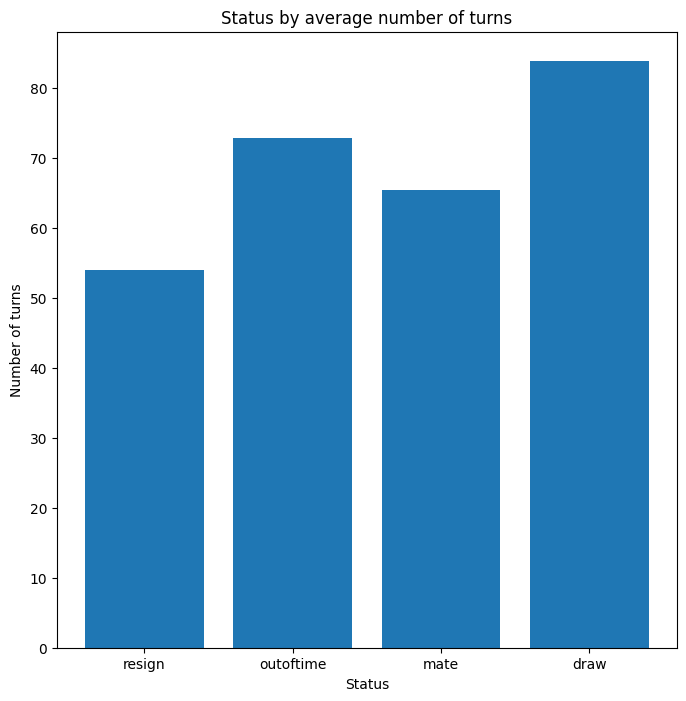

In [21]:
# mean of the labels
turn_df = games.groupby('victory_status').agg(mean('turns').alias("mean_turns"))
turn_pd = turn_df.toPandas()
plt.figure(figsize=(8,8))
plt.bar(x=turn_pd["victory_status"], height=turn_pd["mean_turns"])
plt.title('Status by average number of turns')
plt.xlabel('Status')
plt.ylabel('Number of turns')

#### Evaluation by Winner

<AxesSubplot: xlabel='winner'>

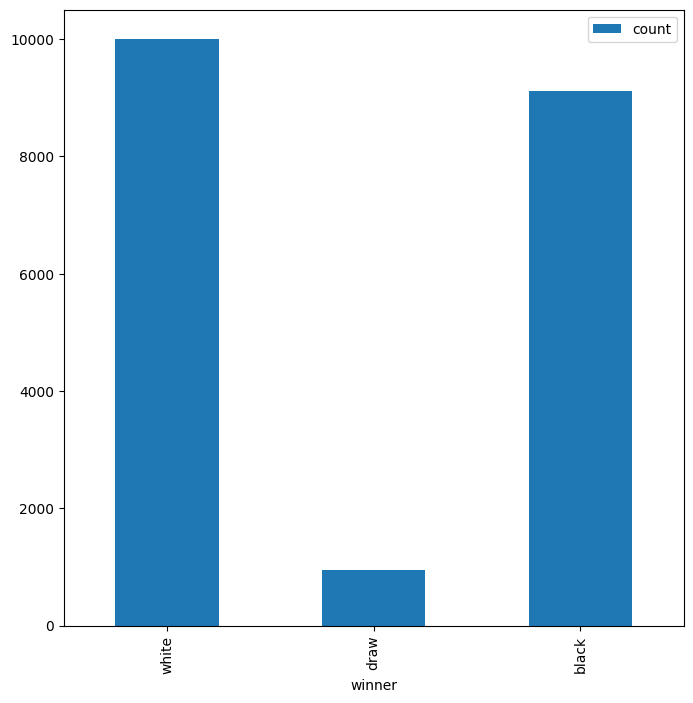

In [22]:
# distribution of the labels
result = games.groupBy("winner").count().sort("winner", ascending=False)
result.toPandas().plot.bar(x='winner',figsize=(8, 8))

Data is not balanced. The result 'draw' is much less in quantity than the others, should be considered when 'winner' column is used as the target in model training.

In [23]:
# number of wins by all opening_names
grouped_df = games.groupBy('opening_name', 'winner').agg(count('winner').alias('wins'))
open_ = grouped_df.orderBy(desc('wins'))
# number of wins by opening_names by player white and black
black_wins = open_[open_['winner'] == 'black']
white_wins = open_[open_['winner'] == 'white']

Text(0, 0.5, 'Number of Wins')

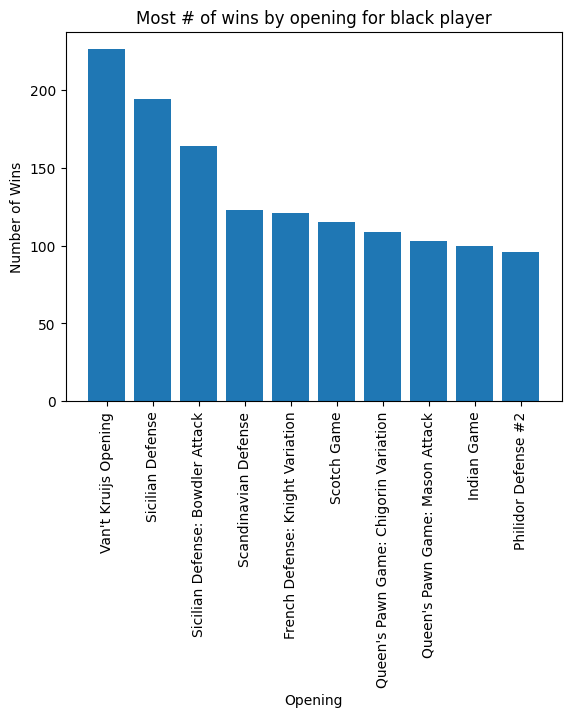

In [24]:
b = black_wins.limit(10)
x = b.toPandas().opening_name
y = b.toPandas().wins
plt.figure(dpi=100)
plt.bar(x, height=y)
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for black player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

Text(0, 0.5, 'Number of Wins')

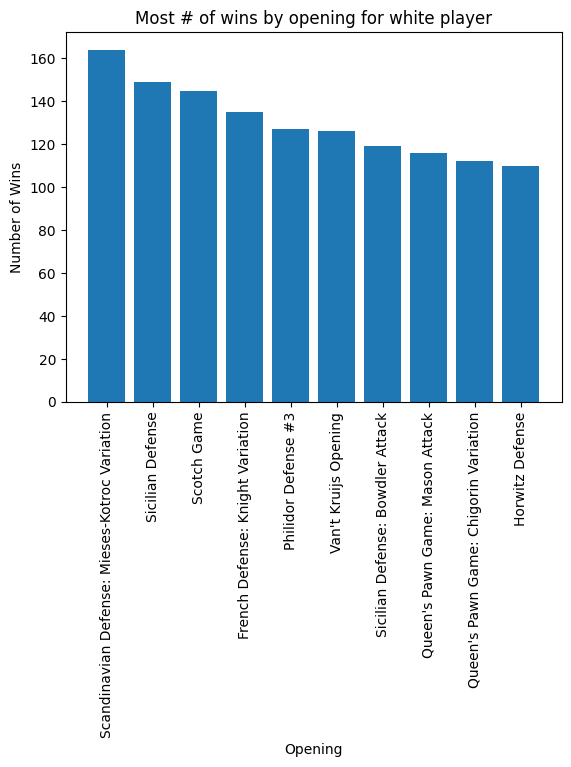

In [25]:
w = white_wins.limit(10)
x = w.toPandas().opening_name
y = w.toPandas().wins
plt.figure(dpi=100)
plt.bar(x, height=y)
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for white player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

These are the top 10 openings which have the most wins for black and white player.

In [26]:
# for each game, it takes the difference between the winner and the loser players' ratings
# if the diff > 0 white's rating is bigger than black 
#             < 0 black's rating is bigger than white

difference = games.withColumn("Difference", (col("white_rating") - col("black_rating")))
difference.select("Winner","Difference").show()

+------+----------+
|Winner|Difference|
+------+----------+
| white|       309|
| black|        61|
| white|        -4|
| white|       -15|
| white|        54|
|  draw|       248|
| white|        97|
| black|      -695|
| black|        47|
| white|       172|
| white|       109|
| black|      -486|
| black|      -555|
| black|      -226|
| white|       -47|
| black|        47|
| black|       -47|
| black|        47|
| black|      -206|
| white|       406|
+------+----------+
only showing top 20 rows



Text(-15.305555555555555, 0.5, 'Rating Difference (White-Black)')

<Figure size 2000x1000 with 0 Axes>

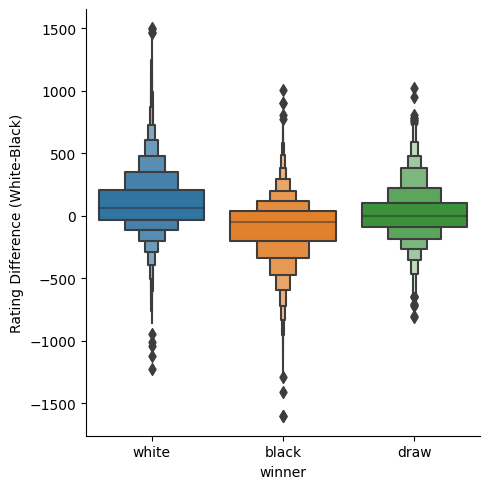

In [27]:
plt.figure(figsize=(20,10))
games_pd = games.toPandas()
games_pd['Difference'] = games_pd['white_rating'] - games_pd['black_rating']
sns.catplot(x='winner', y='Difference', kind='boxen', data=games_pd)
plt.ylabel("Rating Difference (White-Black)")

Text(0, 0.5, 'Difference in rating')

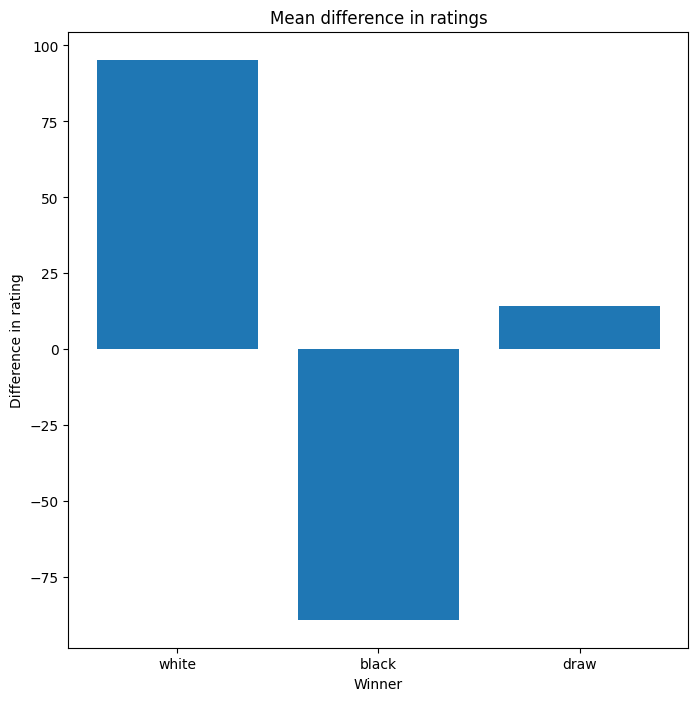

In [28]:
# takes the mean of each label's difference between
mean_df = difference.groupby('winner').agg(mean('Difference').alias('Difference'))
mean_pd = mean_df.toPandas()
plt.figure(figsize=(8,8))
plt.bar(x=mean_pd['winner'], height=mean_pd['Difference'])
plt.title('Mean difference in ratings')
plt.xlabel('Winner')
plt.ylabel('Difference in rating')

Text(0, 0.5, 'Difference in rating')

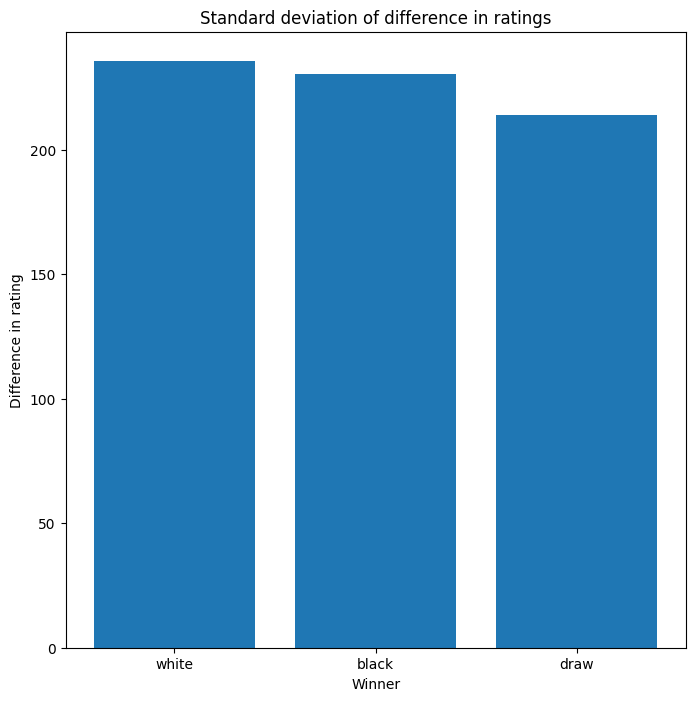

In [29]:
# takes the standard deviation of each label's difference between
std_df = difference.groupby('winner').agg(std('Difference').alias('Difference'))
std_pd = std_df.toPandas()
plt.figure(figsize=(8,8))
plt.bar(x=std_pd['winner'], height=std_pd['Difference'])
plt.title('Standard deviation of difference in ratings')
plt.xlabel('Winner')
plt.ylabel('Difference in rating')

(array([-2000., -1500., -1000.,  -500.,     0.,   500.,  1000.,  1500.,
         2000.]),
 [Text(0, -2000.0, '−2000'),
  Text(0, -1500.0, '−1500'),
  Text(0, -1000.0, '−1000'),
  Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000')])

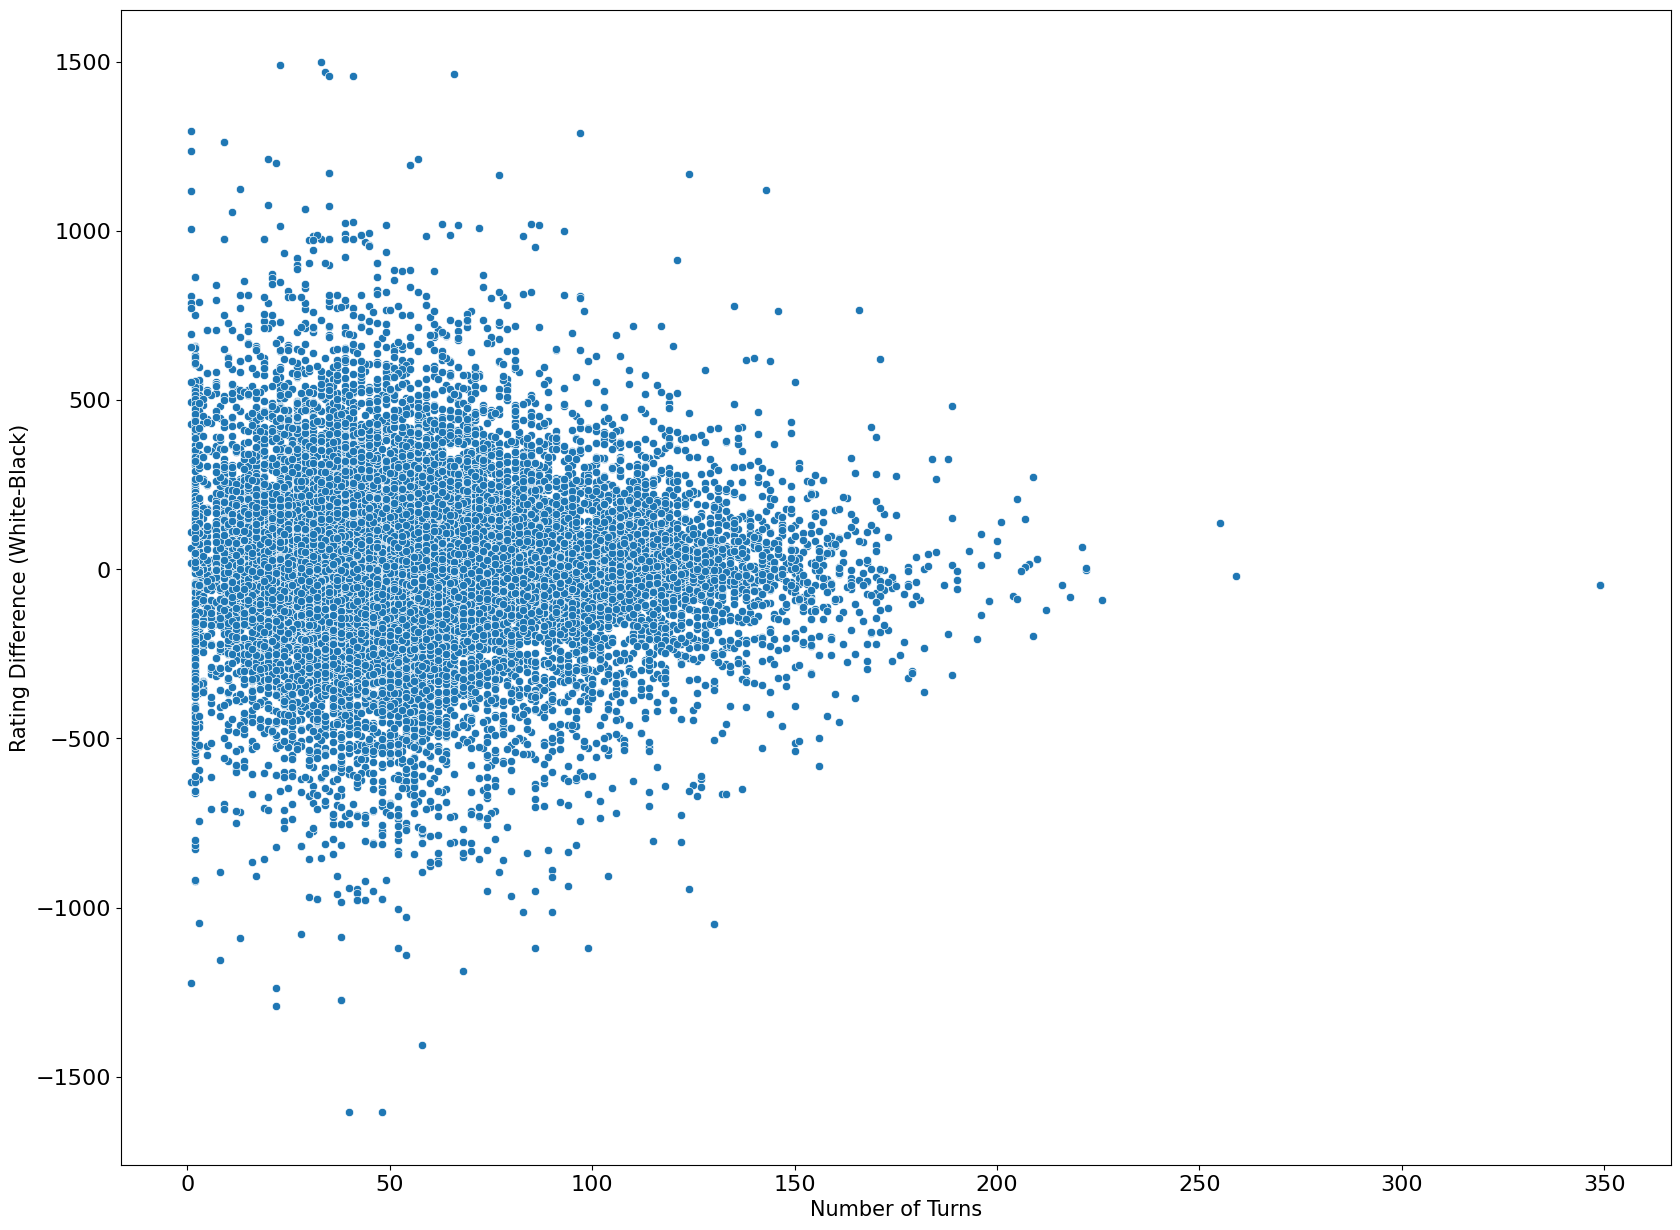

In [30]:
# evaluating rating difference by the distribution of number of turns
plt.figure(figsize=(20,15))
sns.scatterplot(x='turns', y="Difference", data=games_pd)
plt.xticks(fontsize=16)
plt.xlabel("Number of Turns", fontsize=15)
plt.ylabel("Rating Difference (White-Black)", fontsize=15)
plt.yticks(fontsize=16)

## Preprocessing and Analyzing the Data

In [31]:
#controlling duplicated values
window_spec = Window.partitionBy("id")
games_with_count = games.withColumn("count", count("id").over(window_spec))
duplicate_rows = games_with_count.filter("count > 1")
duplicate_rows = duplicate_rows.orderBy("id")
#to see duplicated values
# duplicate_rows.toPandas()
sum_of_duplicated_values = duplicate_rows.select(sum("count")).collect()[0][0]
print("Sum of all duplicated values:", sum_of_duplicated_values)

Sum of all duplicated values: 3968


In [32]:
games = games.dropDuplicates(subset=["id"])

In [33]:
games.describe().toPandas()

,summary,id,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,count,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113
1,mean,None,1.4834131013193103E12,1.4834139747733328E12,60.513838748495786,None,None,None,2.73448511712766E9,1597.300005232041,6.019286096111111E9,1590.045518756867,None,None,None,4.815779835713912
2,stddev,None,2.833975096426027E10,2.8339639419694542E10,33.48826396268022,None,None,None,1.1398530926117226E10,290.0227398102658,2.0835821566559532E10,290.4416944907074,None,None,None,2.7982829080050116
3,min,005lW0Xz,1.376771633173E12,1.376771863841E12,1,draw,black,0+12,--jim--,784,-0olo0-,789,Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...,A00,Alekhine Defense,1
4,max,zzcDhaYF,1.50449314379E12,1.504493827262E12,349,resign,white,90+8,zzzimon,2700,zztopillo,2723,h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...,E98,Zukertort Opening: Wade Defense,28


In [34]:
dataset = games.select("*")

In [35]:
dataset2 = games.select("*")

#### Rate values to INT

In [36]:
#converting to str
dataset = dataset.withColumn("rated", when(col("rated").cast("string") == "true", "true").otherwise("false"))

In [37]:
rate_map,rate_table,dataset = string_to_int("rated",dataset)

In [38]:
printMap_and_showTable(rate_map,rate_table)

{0: 'true', 1: 'false'}
+-----+-----+
|rated|count|
+-----+-----+
|false| 3646|
| true|15467|
+-----+-----+



#### Victory values to INT

In [39]:
vic_map,vic_table,dataset = string_to_int("victory_status",dataset)

In [40]:
printMap_and_showTable(vic_map,vic_table)

{0: 'resign', 1: 'mate', 2: 'outoftime', 3: 'draw'}
+--------------+-----+
|victory_status|count|
+--------------+-----+
|        resign|10695|
|     outoftime| 1598|
|          mate| 5974|
|          draw|  846|
+--------------+-----+



#### Winner values to INT

In [41]:
win_map,win_table,dataset = string_to_int("winner",dataset)

In [42]:
printMap_and_showTable(win_map,win_table)

{0: 'white', 1: 'black', 2: 'draw'}
+------+-----+
|winner|count|
+------+-----+
| white| 9545|
| black| 8680|
|  draw|  888|
+------+-----+



White appears to win approximately 50.0 % of the games  
while Black wins 45.0 % of the games  
and 5.0 % of the games are a draw

#### Opening Name values to INT

In [43]:
openName_map,openName_table,dataset = string_to_int("opening_name",dataset)

In [44]:
printMap_and_showTable(openName_map,openName_table)

{0: 'Sicilian Defense', 1: "Van't Kruijs Opening", 2: 'Sicilian Defense: Bowdler Attack', 3: 'French Defense: Knight Variation', 4: 'Scotch Game', 5: 'Scandinavian Defense: Mieses-Kotroc Variation', 6: "Queen's Pawn Game: Mason Attack", 7: "Queen's Pawn Game: Chigorin Variation", 8: 'Scandinavian Defense', 9: 'Horwitz Defense', 10: 'Caro-Kann Defense', 11: 'Philidor Defense #3', 12: 'Philidor Defense #2', 13: 'Indian Game', 14: 'Modern Defense', 15: 'Italian Game: Anti-Fried Liver Defense', 16: "King's Pawn Game: Wayward Queen Attack", 17: 'Four Knights Game: Italian Variation', 18: 'Owen Defense', 19: 'Sicilian Defense: Old Sicilian', 20: "King's Pawn Game: Leonardis Variation", 21: "Queen's Pawn Game", 22: 'Philidor Defense', 23: 'Ruy Lopez: Steinitz Defense', 24: "Queen's Pawn", 25: "Queen's Gambit Refused: Marshall Defense", 26: "Bishop's Opening", 27: 'French Defense: Normal Variation', 28: 'Hungarian Opening', 29: "Queen's Gambit Declined", 30: "Queen's Pawn Game: Zukertort Varia

+--------------------+-----+
|        opening_name|count|
+--------------------+-----+
|Alekhine Defense:...|    3|
|King's Indian Att...|    4|
|Sicilian Defense:...|    2|
|Caro-Kann Defense...|    1|
|Owen Defense: Smi...|    2|
|Sicilian Defense:...|   48|
|Sicilian Defense:...|    1|
|Queen's Gambit Ac...|   11|
|French Defense: C...|    8|
|French Defense: S...|   10|
|French Defense: W...|    1|
|King's Pawn Game:...|   78|
|  St. George Defense|   43|
|Nimzowitsch Defen...|   24|
|Pirc Defense: Aus...|    6|
|Scotch Game: Mala...|    6|
|Ruy Lopez: Berlin...|    5|
|Nimzo-Larsen Atta...|    6|
|French Defense: F...|    1|
|Sicilian Defense:...|    1|
+--------------------+-----+
only showing top 20 rows



#### Opening eco values to INT

In [45]:
openEco_map,openEco_table,dataset = string_to_int("opening_eco",dataset)

In [46]:
printMap_and_showTable(openEco_map,openEco_table)

{0: 'A00', 1: 'C00', 2: 'D00', 3: 'B01', 4: 'C41', 5: 'C20', 6: 'A40', 7: 'B00', 8: 'B20', 9: 'C50', 10: 'C40', 11: 'D02', 12: 'C44', 13: 'C42', 14: 'B07', 15: 'C55', 16: 'C45', 17: 'C02', 18: 'A04', 19: 'C46', 20: 'A45', 21: 'B21', 22: 'B50', 23: 'B30', 24: 'D20', 25: 'B10', 26: 'B06', 27: 'C21', 28: 'D06', 29: 'A01', 30: 'B12', 31: 'C01', 32: 'B02', 33: 'C23', 34: 'D30', 35: 'C62', 36: 'A10', 37: 'B40', 38: 'B32', 39: 'C57', 40: 'A06', 41: 'C24', 42: 'D10', 43: 'C65', 44: 'B23', 45: 'C60', 46: 'B90', 47: 'A20', 48: 'B22', 49: 'C68', 50: 'C30', 51: 'D01', 52: 'C53', 53: 'B13', 54: 'A46', 55: 'C48', 56: 'E20', 57: 'A03', 58: 'A43', 59: 'D31', 60: 'A02', 61: 'B54', 62: 'C22', 63: 'A41', 64: 'C34', 65: 'D35', 66: 'C70', 67: 'B27', 68: 'C26', 69: 'A21', 70: 'E61', 71: 'A15', 72: 'C10', 73: 'A22', 74: 'A80', 75: 'C64', 76: 'C47', 77: 'A13', 78: 'B25', 79: 'B33', 80: 'E00', 81: 'D07', 82: 'D15', 83: 'B08', 84: 'C77', 85: 'D04', 86: 'D11', 87: 'C11', 88: 'C54', 89: 'C61', 90: 'A30', 91: 'B34

#### Time Inc values to INT

In [47]:
timeInc_map,timeInc_table,dataset = string_to_int("time_increment",dataset)

In [48]:
printMap_and_showTable(timeInc_map,timeInc_table)

{0: '10+0', 1: '15+0', 2: '15+15', 3: '5+5', 4: '5+8', 5: '8+0', 6: '10+5', 7: '15+10', 8: '20+0', 9: '30+0', 10: '10+10', 11: '15+5', 12: '7+2', 13: '10+2', 14: '30+30', 15: '5+10', 16: '10+3', 17: '25+0', 18: '10+8', 19: '20+10', 20: '15+2', 21: '10+15', 22: '9+0', 23: '45+45', 24: '20+5', 25: '8+8', 26: '180+0', 27: '15+8', 28: '30+10', 29: '10+1', 30: '8+5', 31: '12+0', 32: '20+15', 33: '7+5', 34: '180+180', 35: '60+0', 36: '15+3', 37: '7+7', 38: '7+9', 39: '20+20', 40: '20+3', 41: '6+5', 42: '15+1', 43: '7+3', 44: '8+2', 45: '9+5', 46: '12+10', 47: '11+0', 48: '5+7', 49: '30+5', 50: '5+6', 51: '7+4', 52: '15+14', 53: '7+8', 54: '5+15', 55: '4+6', 56: '7+10', 57: '45+0', 58: '7+15', 59: '9+8', 60: '3+8', 61: '10+4', 62: '2+10', 63: '25+3', 64: '8+10', 65: '10+6', 66: '25+5', 67: '8+3', 68: '25+25', 69: '6+8', 70: '14+0', 71: '20+60', 72: '20+8', 73: '6+4', 74: '6+6', 75: '10+30', 76: '16+0', 77: '20+30', 78: '12+5', 79: '15+60', 80: '5+60', 81: '6+3', 82: '12+12', 83: '6+10', 84: '

#### Combining or Dropping the Redundant/Non-informing Columns

In [49]:
dataset = dataset.withColumn("game_duration", (col("end_time") - col("start_time")).cast("double"))

In [50]:
columns_to_drop = ["id", "rated", "victory_status", "winner", "start_time", "end_time", "white_id", "black_id", "moves","opening_name","opening_eco","time_increment"]
dataset = dataset.drop(*columns_to_drop)

"id" column is dropped since it is does not provide information for analysis.
Our goal is to analyze the moves and its results, not the specific player's chess skills. So, the "white_id" and "black_id" columns are also dropped, but their ratings remain.  
"created_at" and "last_move_at" columns are dropped and the difference was added to new column "game_duration".  
Other columns are dropped because they are stored in one hot form in different columns (_ind).  
Original dataset is stored in "games" dataframe. Preprocessed data ("dataset") will be used from now on to perform analysis and prediction.

In [51]:
dataset.limit(5).toPandas()

,turns,white_rating,black_rating,opening_ply,rated_ind,victory_status_ind,winner_ind,opening_name_ind,opening_eco_ind,time_increment_ind,game_duration
0,37,1500,1479,10,1,0,0,237,135,6,371839.0
1,36,1890,1838,4,0,0,1,29,34,5,287937.0
2,54,1207,1588,7,0,1,1,444,17,24,0.0
3,114,1689,2201,3,0,0,1,2,8,5,0.0
4,47,1568,1561,4,0,1,0,72,10,19,770082.0


In [52]:
dataset.describe().toPandas()

,summary,turns,white_rating,black_rating,opening_ply,rated_ind,victory_status_ind,winner_ind,opening_name_ind,opening_eco_ind,time_increment_ind,game_duration
0,count,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113
1,mean,60.513838748495786,1597.300005232041,1590.045518756867,4.815779835713912,0.19076021556008999,0.6125673625281223,0.5470622089677183,203.51530371998118,40.22372207398106,20.535656359545857,873454.0226547376
2,stddev,33.48826396268026,290.02273981026667,290.441694490707,2.7982829080050102,0.3929107187179047,0.8186318372429172,0.583715704610375,275.13278842195837,54.36814715524872,47.70505405518891,4927360.503480385
3,min,1,784,789,1,0,0,0,0,0,0,0.0
4,max,349,2700,2723,28,1,3,2,1476,364,399,6.05844701E8


In [53]:
"""
Checked outlier values but not dropped all because:
    -some columns are changed and they should be misunderstood by function
        for ex: victory_status_ind has "resign,outoftime,mate,draw" if there are so many resign   draw(3) matches could be dropped.
    -want to check by manually to if there are too many values will be dropped
    -want to control before deletetion
"""
for i, column in enumerate(dataset.columns , start=0):
    print(column)
    count_outliers(i)
    print("")

turns
lower:  -26.0 - upper:  142.0
will be dropped:  412

white_rating
lower:  814.5 - upper:  2378.5
will be dropped:  130

black_rating
lower:  807.5 - upper:  2371.5
will be dropped:  92

opening_ply
lower:  -1.5 - upper:  10.5
will be dropped:  859

rated_ind
lower:  0.0 - upper:  0.0
will be dropped:  0

victory_status_ind
lower:  -1.5 - upper:  2.5
will be dropped:  846

winner_ind
lower:  -1.5 - upper:  2.5
will be dropped:  0

opening_name_ind
lower:  -344.5 - upper:  635.5
will be dropped:  1620

opening_eco_ind
lower:  -63.0 - upper:  121.0
will be dropped:  1646

time_increment_ind
lower:  -22.5 - upper:  37.5
will be dropped:  2824

game_duration
lower:  -1171578.0 - upper:  1952630.0
will be dropped:  1386



turns, white&black_rating, opening_play, game_duration will be dropped 

In [54]:
dataset = drop_outliers(dataset,"turns")
dataset = drop_outliers(dataset,"white_rating")
dataset = drop_outliers(dataset,"black_rating")
dataset = drop_outliers(dataset,"opening_ply")
dataset = drop_outliers(dataset,"game_duration")

In [55]:
dataset.describe().toPandas()

,summary,turns,white_rating,black_rating,opening_ply,rated_ind,victory_status_ind,winner_ind,opening_name_ind,opening_eco_ind,time_increment_ind,game_duration
0,count,16482,16482,16482,16482,16482,16482,16482,16482,16482,16482,16482
1,mean,56.85972576143672,1575.547020992598,1569.3219269506128,4.422885572139304,0.18492901346923918,0.5848198034219149,0.5350685596408203,178.88526877806092,34.32981434291955,19.774602596772237,337885.80669821624
2,stddev,29.812208475082553,275.65217238742196,278.6531559615334,2.2113673313846323,0.38825174712553767,0.7895440237734537,0.5718891850746204,244.8701605933472,45.27010478838347,47.045638833834566,436799.15578640735
3,min,1,826,818,1,0,0,0,0,0,0,0.0
4,max,142,2367,2358,10,1,3,2,1475,363,399,1847296.0


### Correlation Matrix

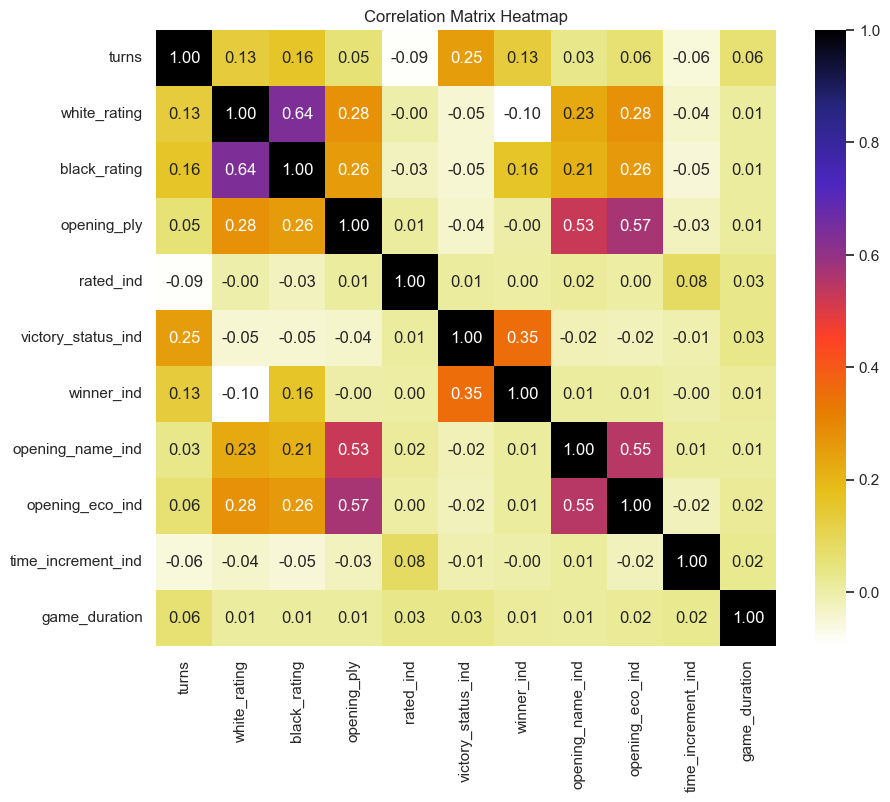

In [55]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=dataset.columns, outputCol="features")
assembled_df = assembler.transform(dataset)

correlation_matrix = Correlation.corr(assembled_df, "features", "pearson")

correlation_matrix_pd = correlation_matrix.select("pearson(features)").collect()[0][0]
correlation_matrix_np = np.array(correlation_matrix_pd.toArray())

sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap=plt.cm.CMRmap_r, xticklabels=dataset.columns, yticklabels=dataset.columns)
plt.title("Correlation Matrix Heatmap")
plt.show()

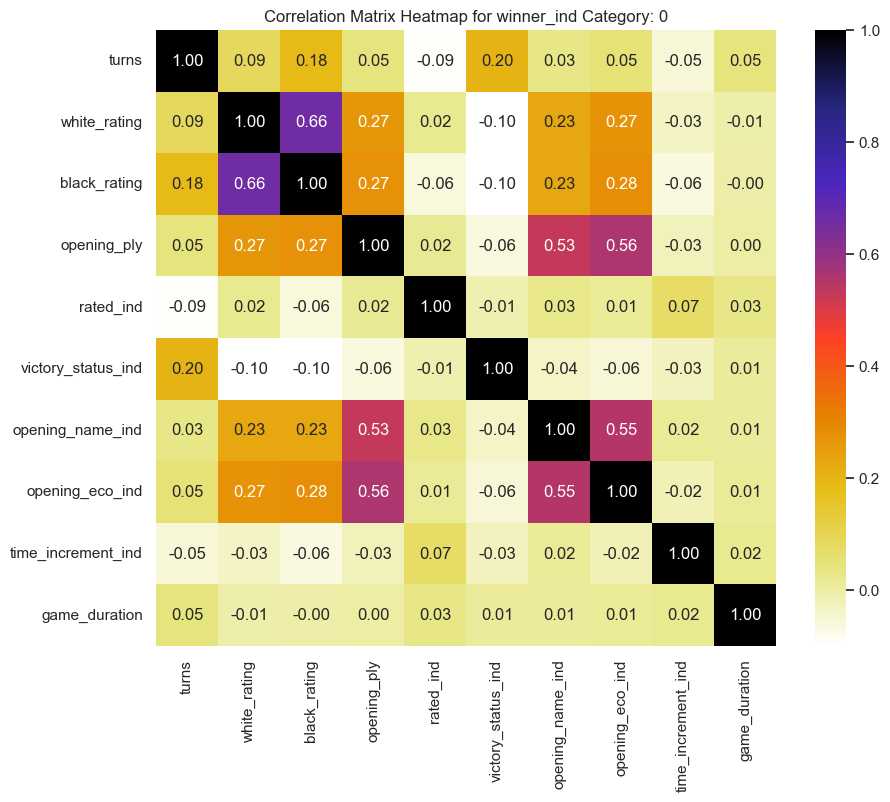

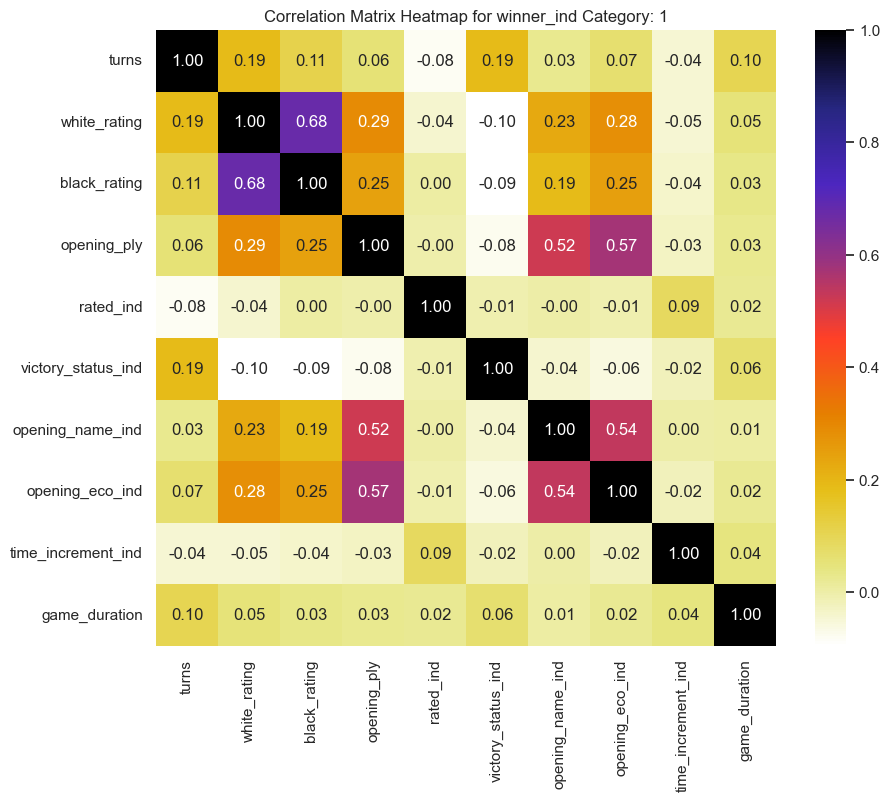

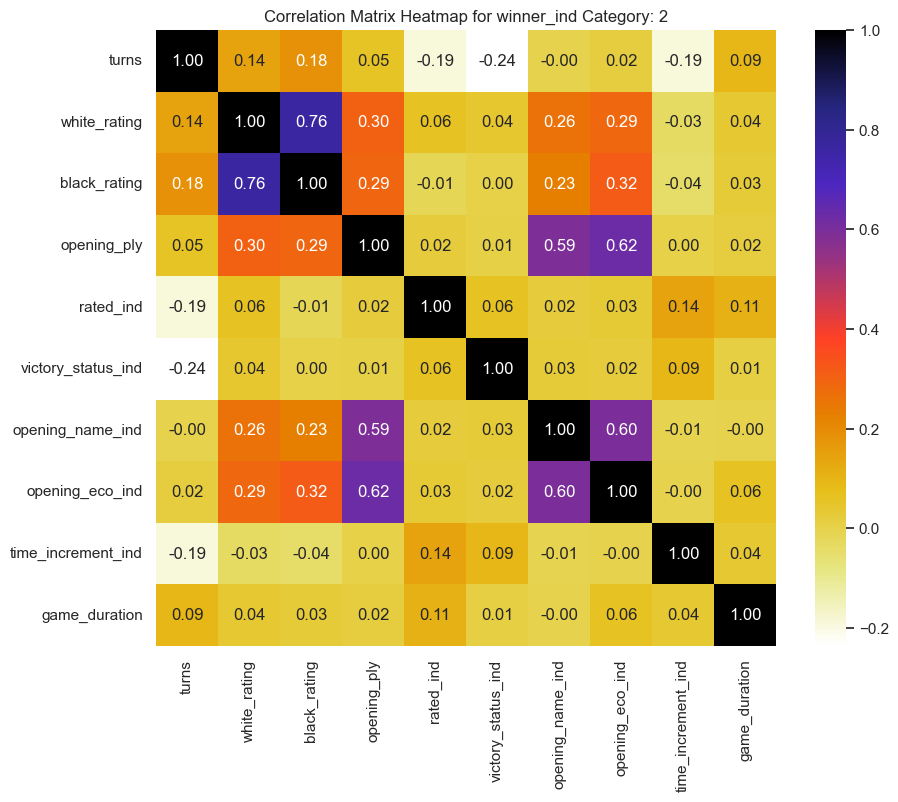

In [56]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Örnek olarak 'victory_status_ind' sütununda yer alabilecek kategorileri listeye alalım
victory_categories = [0, 1, 2]  # Değiştirmeniz gereken kategori isimleri

# Her bir kategori için ayrı korelasyon matrislerini hesaplayıp görselleştirme
for category in victory_categories:
    filtered_dataset = dataset.filter(dataset['winner_ind'] == category)
    
    assembler = VectorAssembler(inputCols=[col for col in filtered_dataset.columns if col != 'winner_ind'],
                                outputCol="features")
    assembled_df = assembler.transform(filtered_dataset)
    
    correlation_matrix = Correlation.corr(assembled_df, "features", "pearson")
    correlation_matrix_pd = correlation_matrix.select("pearson(features)").collect()[0][0]
    correlation_matrix_np = np.array(correlation_matrix_pd.toArray())
    
    sns.set(style="white")
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap=plt.cm.CMRmap_r,
                xticklabels=[col for col in filtered_dataset.columns if col != 'winner_ind'],
                yticklabels=[col for col in filtered_dataset.columns if col != 'winner_ind'])
    plt.title(f"Correlation Matrix Heatmap for winner_ind Category: {category}")
    plt.show()

TODO comment on the heatmap

#### How to scale the data?

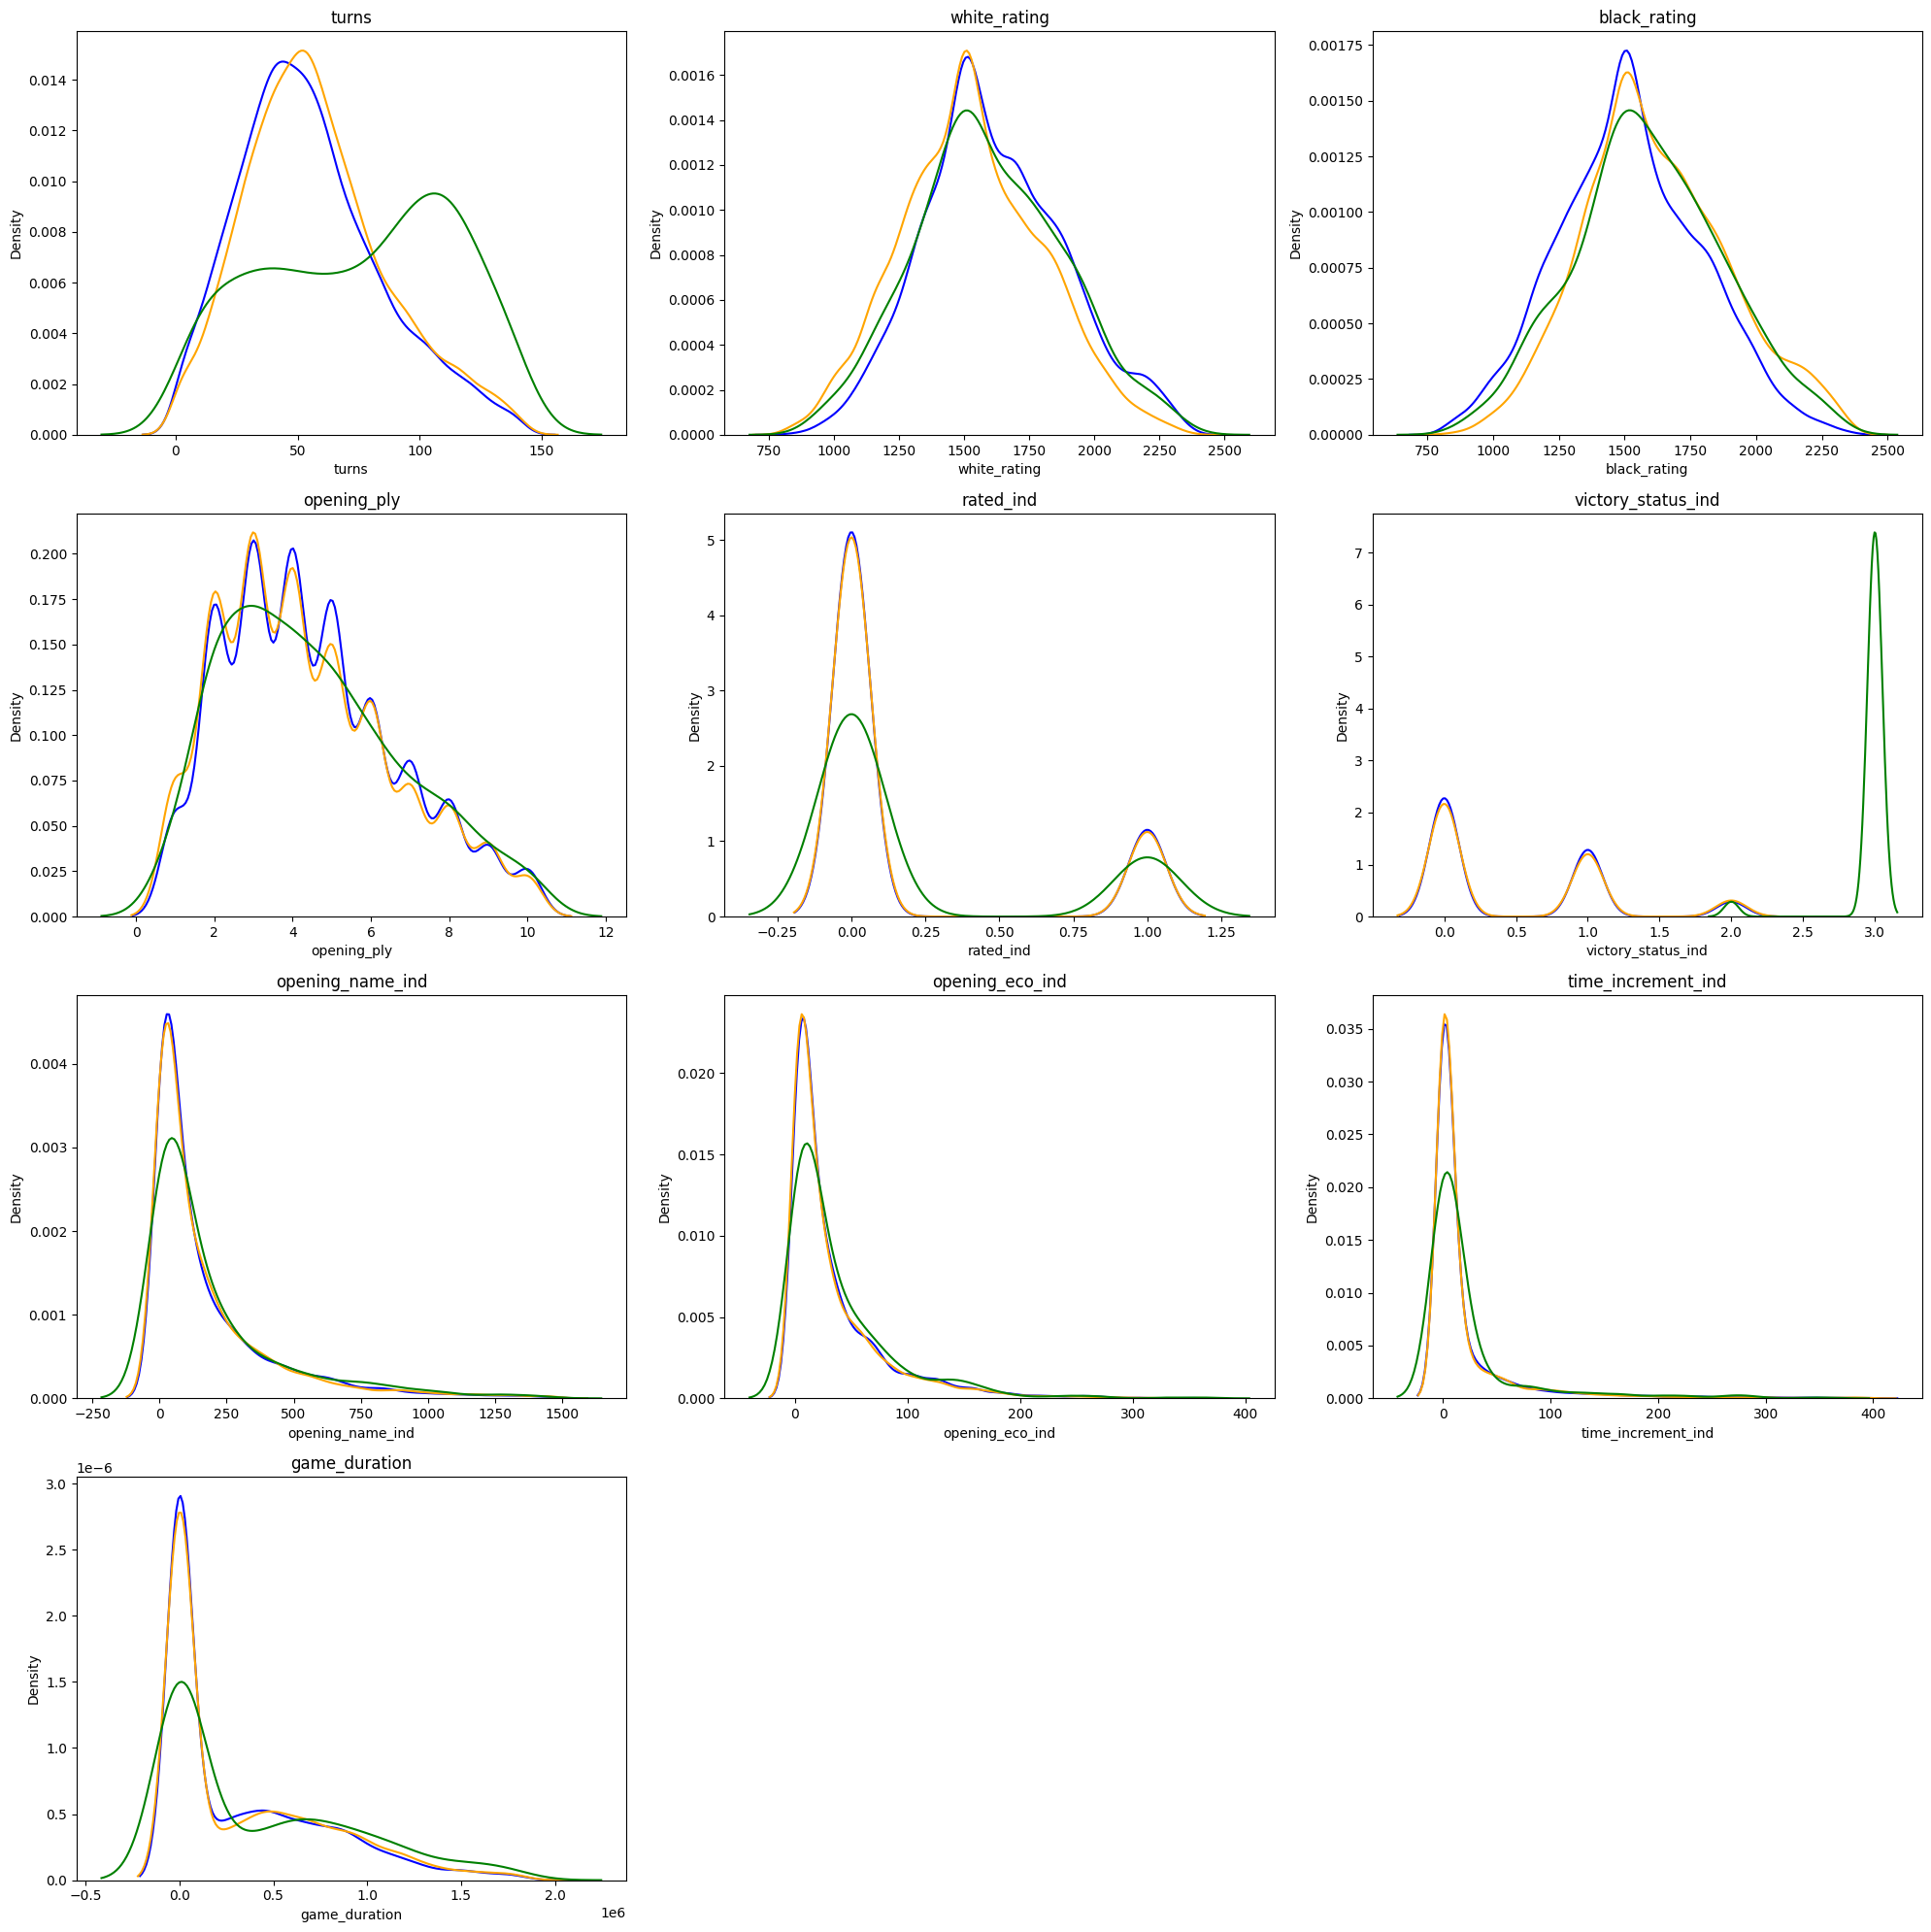

In [56]:
data_0 = dataset.where(col("winner_ind")==0)
data_1 = dataset.where(col("winner_ind")==1)
data_2 = dataset.where(col("winner_ind")==2)

cols = dataset.columns
cols.remove('winner_ind')
fig,ax =plt.subplots(4,3,figsize=(20,20))
for feature,axes in zip(cols,ax.ravel()):
    sns.kdeplot(data_0.select(feature).toPandas()[feature],color='blue',ax=axes)   # white
    sns.kdeplot(data_1.select(feature).toPandas()[feature],color='orange',ax=axes) # black
    sns.kdeplot(data_2.select(feature).toPandas()[feature],color='green',ax=axes)  # draw
    axes.set_title(feature)
    
fig.delaxes(ax[3,1])
fig.delaxes(ax[3,2])
plt.tight_layout()

From most of the features, it can be said that data is positively skewed and not normally distributed. We might have issues in variability since the spread is not that wide except for a few features. Looks like game_duration will not be providing many information to us since the data there does not look very reliable.  
From these informations, the most appropriate Scaler for this data would be RobustScaler.

In [57]:
dataa = dataset.toPandas()
sns.pairplot(data=dataa,hue='winner_ind')

Error in callback <function flush_figures at 0x000001B43ECE9630> (for post_execute):


KeyboardInterrupt: 

This is the visualization of a pair plot. However, probably because our data is unbalanced, this graph does not really provide any new information other than it being unbalanced.

### PCA

In [58]:
cols = dataset.columns
cols.remove('winner_ind')
cols

['turns',
 'white_rating',
 'black_rating',
 'opening_ply',
 'rated_ind',
 'victory_status_ind',
 'opening_name_ind',
 'opening_eco_ind',
 'time_increment_ind',
 'game_duration']

In [70]:
VecAssembler = VectorAssembler(inputCols=cols,outputCol="features")
VecAssembler.transform(dataset).select("features","winner_ind").show()

+--------------------+----------+
|            features|winner_ind|
+--------------------+----------+
|[37.0,1500.0,1479...|         0|
|[36.0,1890.0,1838...|         1|
|[54.0,1207.0,1588...|         1|
|[114.0,1689.0,220...|         1|
|[47.0,1568.0,1561...|         0|
|[29.0,1418.0,1330...|         0|
|[75.0,1500.0,1801...|         0|
|[95.0,1203.0,894....|         0|
|[35.0,2126.0,1225...|         0|
|[62.0,1578.0,1505...|         1|
|[138.0,1537.0,150...|         1|
|[57.0,1710.0,1777...|         0|
|[60.0,1156.0,1442...|         1|
|[102.0,2085.0,230...|         1|
|[12.0,1598.0,1862...|         0|
|[58.0,1178.0,1616...|         1|
|[78.0,1672.0,1680...|         1|
|[51.0,1791.0,1633...|         1|
|[19.0,1682.0,1500...|         0|
|[99.0,1872.0,2021...|         0|
+--------------------+----------+
only showing top 20 rows



In [72]:
train,test = dataset.randomSplit([0.9,0.1], seed=42)

In [73]:
#scale the data
scaler = RobustScaler(inputCol="features",outputCol="features_scaled")

#transform the datasets using a pipeline
feature_pipe = Pipeline(stages=[VecAssembler,scaler]).fit(train)
train = feature_pipe.transform(train)
test = feature_pipe.transform(test)

In [74]:
train.select("features","features_scaled").show(5)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[1.0,1431.0,1367....|[0.02564102564102...|
|(10,[0,1,2,3,6],[...|(10,[0,1,2,3,6],[...|
|[1.0,1484.0,2113....|[0.02564102564102...|
|[1.0,1670.0,1175....|[0.02564102564102...|
|[1.0,1778.0,1349....|[0.02564102564102...|
+--------------------+--------------------+
only showing top 5 rows



In [63]:
# PCA decomposition to 2 features
pca = PCA(k=3,inputCol="features",outputCol="pca").fit(train)
data = pca.transform(train).select("pca","winner_ind")
data.show(5)

+--------------------+----------+
|                 pca|winner_ind|
+--------------------+----------+
|[-2931.0006278032...|         0|
|[-6.0943300600125...|         1|
|[-7.3215459555866...|         0|
|[-8.0983862775657...|         0|
|[-6.7784255020535...|         0|
+--------------------+----------+
only showing top 5 rows



In [64]:
# split into three to plot
data = data.withColumn("pca",vector_to_array("pca")).select(col("winner_ind"),col("pca")[0],col("pca")[1],col("pca")[2])
data.show(5)

+----------+--------------------+-------------------+------------------+
|winner_ind|              pca[0]|             pca[1]|            pca[2]|
+----------+--------------------+-------------------+------------------+
|         0| -2931.0006278032984|-1943.6263472190867| 438.9503728654104|
|         1|-6.09433006001257...|-1881.9284767932957| 652.3059025721601|
|         0|-7.32154595558669...| -2473.969783894736|  645.778441947579|
|         0|-8.09838627756579...| -2889.437267253123| 808.8287512989011|
|         0|-6.77842550205353...|-1975.0696298579703|441.65364584951357|
+----------+--------------------+-------------------+------------------+
only showing top 5 rows



In [134]:
data = data.toPandas()
fig = px.scatter_3d(data, x='pca[0]', y='pca[1]', z='pca[2]',color='winner_ind',title="Scatterplot of PCA Features",color_continuous_scale=px.colors.sequential.Viridis)
fig.update(layout_coloraxis_showscale=False)
fig.show()

NameError: name 'data' is not defined

Using PCA, we tried to reduce the number of features to 3 from 10, so that they can be visualized. As you can see, there is an excellent separation between both the classes. Let's use Logistic Classifier or Support Vector Classifier for making the model

In [86]:
train = train.drop("victory_status_ind")
test = test.drop("victory_status_ind")

# Training the Data

### Logistic Regression

In [89]:
lr = LogisticRegression(featuresCol="features_scaled",labelCol="winner_ind",predictionCol='prediction_lr')
params = ParamGridBuilder().addGrid(lr.maxIter,[50,75,100,150,200]).addGrid(lr.regParam,[0,0.0001,0.001,0.01,0.1,0.5]).build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_lr',labelCol='winner_ind',metricName='f1')
CValidator = CrossValidator(estimator=lr,estimatorParamMaps=params,evaluator=evaluator,numFolds=5)
CValidator_lr = CValidator.fit(train)

#predictions on test data
predictions_lr= CValidator_lr.transform(test).select('prediction_lr','winner_ind')
predictions_lr.show(5)

+-------------+----------+
|prediction_lr|winner_ind|
+-------------+----------+
|          0.0|         0|
|          1.0|         1|
|          1.0|         0|
|          1.0|         1|
|          1.0|         1|
+-------------+----------+
only showing top 5 rows



In [90]:
predictions_lr= CValidator_lr.transform(test).select('winner_ind',"white_rating","black_rating",'prediction_lr')
predictions_lr.show(50)

+----------+------------+------------+-------------+
|winner_ind|white_rating|black_rating|prediction_lr|
+----------+------------+------------+-------------+
|         0|        2032|        1223|          0.0|
|         1|         830|        1460|          1.0|
|         0|        1076|        1319|          1.0|
|         1|        1146|        1572|          1.0|
|         1|        1336|        1516|          1.0|
|         1|        1430|        1366|          0.0|
|         1|        1500|        1586|          1.0|
|         1|        1500|        1713|          1.0|
|         1|        1599|        1769|          1.0|
|         1|        1816|        2230|          1.0|
|         1|        2029|        2025|          0.0|
|         1|        1148|        1614|          1.0|
|         0|        1242|        1134|          0.0|
|         0|        1390|         885|          0.0|
|         0|        1500|        1229|          0.0|
|         2|        1500|        1626|        

Accuracy: 0.6712
Precision: 0.6727
Recall: 0.6723
F1 Score: 0.6712
Confusion Matrix:


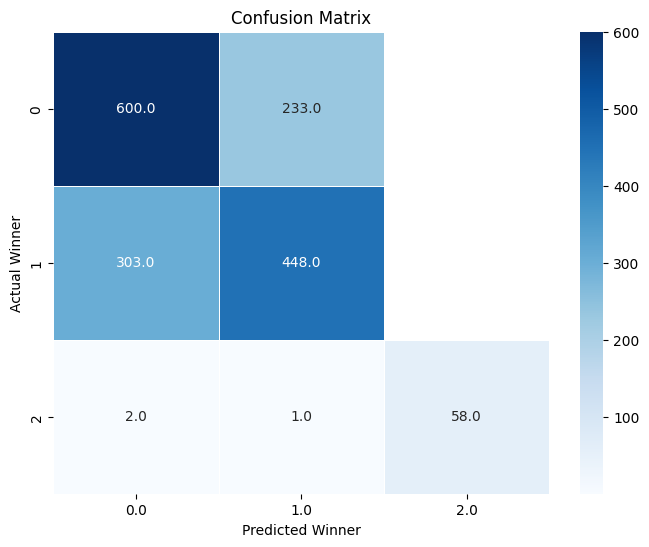

In [91]:
accuracy = evaluator.evaluate(predictions_lr)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_lr, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_lr, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_lr, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_lr.groupBy('winner_ind', 'prediction_lr').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_lr', values='count')
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

### DecisionTreeClassifier

In [87]:
dt = DecisionTreeClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_dt', maxDepth=5)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_dt', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=dt, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_dt = CValidator.fit(train)

predictions_dt = CValidator_dt.transform(test).select("prediction_dt", "winner_ind")
predictions_dt.show(5)

+-------------+----------+
|prediction_dt|winner_ind|
+-------------+----------+
|          0.0|         0|
|          1.0|         1|
|          1.0|         0|
|          1.0|         1|
|          1.0|         1|
+-------------+----------+
only showing top 5 rows



Accuracy: 0.6124
Precision: 0.6554
Recall: 0.6353
F1 Score: 0.6124
Confusion Matrix:


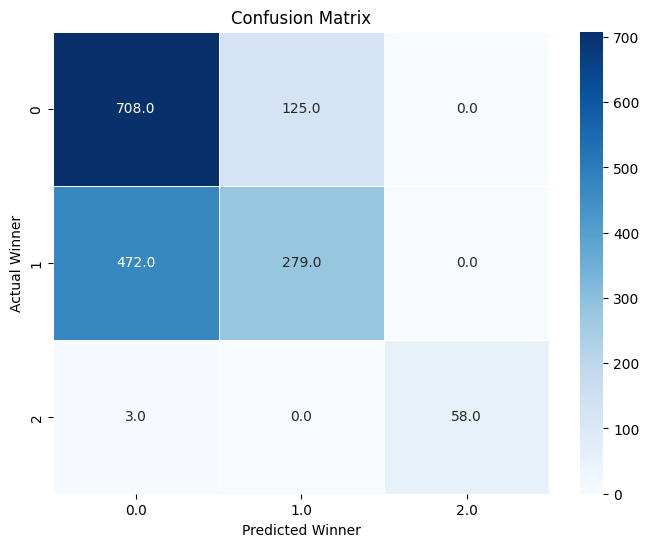

In [88]:
accuracy = evaluator.evaluate(predictions_dt)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_dt, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_dt.groupBy('winner_ind', 'prediction_dt').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_dt', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

The 0.0 (NaN) values are happening because sometimes when you use the 'pivot' function to create the confusion matrix, it might not cover all possible combinations of true and predicted labels, resulting in NaN values for the combinations that did not occur.

### RandomForestClassifier

In [99]:
rf = RandomForestClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_rf', numTrees=10, maxDepth=5)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_rf', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=rf, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_rf = CValidator.fit(train)

predictions_rf = CValidator_rf.transform(test).select("prediction_rf", "winner_ind")
predictions_rf.show(5)

+-------------+----------+
|prediction_rf|winner_ind|
+-------------+----------+
|          0.0|         0|
|          0.0|         0|
|          1.0|         1|
|          1.0|         1|
|          1.0|         1|
+-------------+----------+
only showing top 5 rows



Accuracy: 0.6268
Precision: 0.6428
Recall: 0.6360
F1 Score: 0.6268
Confusion Matrix:
prediction_rf     0.0    1.0    2.0
winner_ind                         
0              1443.0  425.0    0.0
1               940.0  797.0    0.0
2                 2.0    4.0  156.0


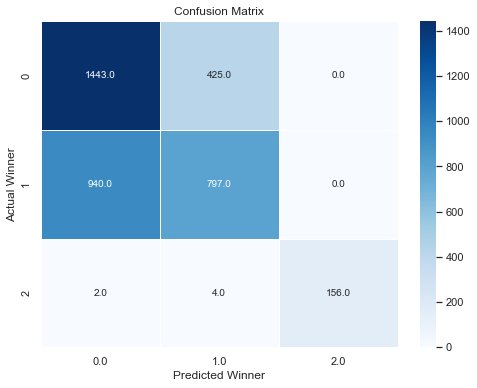

In [102]:
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_rf.groupBy('winner_ind', 'prediction_rf').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_rf', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

### Multilayer Perceptron Classifier (Neural Network)

In [103]:
layers = [len(train.select('features_scaled').first()[0]), 10, 5, len(train.select('winner_ind').distinct().collect())]

mlp = MultilayerPerceptronClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_mlp', maxIter=100, layers=layers)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_mlp', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=mlp, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_mlp = CValidator.fit(train)

predictions_mlp = CValidator_mlp.transform(test).select("prediction_mlp", "winner_ind")
predictions_mlp.show(5)

+--------------+----------+
|prediction_mlp|winner_ind|
+--------------+----------+
|           0.0|         0|
|           0.0|         0|
|           0.0|         1|
|           1.0|         1|
|           1.0|         1|
+--------------+----------+
only showing top 5 rows



Accuracy: 0.6637
Precision: 0.6659
Recall: 0.6653
F1 Score: 0.6637
Confusion Matrix:


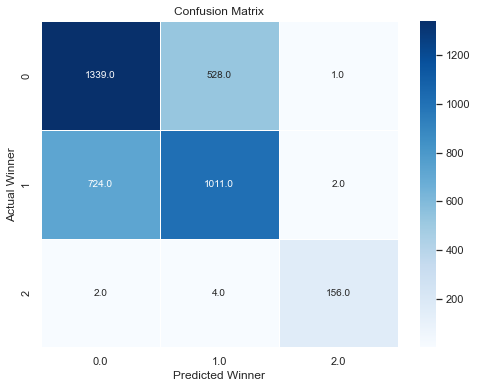

In [105]:
accuracy = evaluator.evaluate(predictions_mlp)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_mlp.groupBy('winner_ind', 'prediction_mlp').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_mlp', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

### Saving the model and feature pipeline

In [ ]:
#Save feature pipe
feature_pipe.save('feature_pipe')

#Save the model
CValidator_svc.bestModel.save('bank_note_model_svc')

### Deployment using StreamLit Library ???